In [8]:
import pandas as pd
df_tweets = pd.read_csv(r'preprocessed_tweets/example_processed_tweets.csv', delimiter = ",", encoding='latin-1')

df_tweets = df_tweets.dropna()
df_tweets

,TWEET,DATE,TIME
0,Soon it will seem like all rotation will be fr...,28/10/2021,21:28:23
1,"Screw Elon Musk, the selfish bastard. This sea...",28/10/2021,21:27:17
2,"Detroit automakers would be able to offer $4,5...",28/10/2021,21:27:03
3,A lot of people and 401ks made a lot of money ...,28/10/2021,18:18:40


In [3]:
# #df_tweets = df_tweets.drop([259255])
#df_tweets = df_tweets[:147568]
# #df_tweets = df_tweets.drop(df_tweets.tail(50000).index,inplace=True)
#df_tweets.tail()
#df_tweets.to_csv(r'C:\Users\wierc\Desktop\inz\stock_ml\btc_processed_tweets_01_04_21_05.csv', index = False)
# # #df_tweets
#df_tweets.columns = ["SENTIMENT", "TWEET"]
df_tweets

,TWEET,DATE,TIME
0,Soon it will seem like all rotation will be fr...,28/10/2021,21:28:23
1,"Screw Elon Musk, the selfish bastard. This sea...",28/10/2021,21:27:17
2,"Detroit automakers would be able to offer $4,5...",28/10/2021,21:27:03
3,A lot of people and 401ks made a lot of money ...,28/10/2021,18:18:40


In [9]:
#!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [10]:
sentence = "Today was a great day to buy amazon stock"
print(sentence)

print(tokenizer.tokenize(sentence))
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))
tokens_pt = tokenizer(sentence, return_tensors="pt")
for key, value in tokens_pt.items():
    print("{}:\n\t{}".format(key, value))

Today was a great day to buy amazon stock
['today', 'was', 'a', 'great', 'day', 'to', 'buy', 'amazon', 'stock']
input_ids:
	tensor([[ 101, 2651, 2001, 1037, 2307, 2154, 2000, 4965, 9733, 4518,  102]])
token_type_ids:
	tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
	tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [11]:
for sentence in df_tweets["TWEET"][1:10]:
  print(sentence)
  tokens_pt = tokenizer(sentence, return_tensors="pt")
  for key, value in tokens_pt.items():
      print("{}:\n\t{}".format(key, value))

Screw Elon Musk, the selfish bastard. This seals the deal for me - I'll never own a Tesla even if I could.
input_ids:
	tensor([[  101, 11224,  3449,  2239, 14163,  6711,  1010,  1996, 14337,  8444,
          1012,  2023, 13945,  1996,  3066,  2005,  2033,  1011,  1045,  1005,
          2222,  2196,  2219,  1037, 26060,  2130,  2065,  1045,  2071,  1012,
           102]])
token_type_ids:
	tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]])
attention_mask:
	tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])
Detroit automakers would be able to offer $4,500 more in tax credits to U.S. electric car buyers than rivals such as Tesla and Toyota under Biden's new proposal
input_ids:
	tensor([[  101,  5626,  8285, 12088,  2052,  2022,  2583,  2000,  3749,  1002,
          1018,  1010,  3156,  2062,  1999,  4171,  6495,  2000,  1057,  1012,
          1055,  1012,  3751,  2482

In [12]:
import numpy as np
def softmax(z): return np.exp(z)/((np.exp(z)).sum())

In [13]:
import torch, math

def get_output(df, print_sentences = True, print_output = True):
  df_sentences = df["TWEET"]
  positive = []
  negative = []
  neutral = []
  predictions = []
  sentiment_score = []

  label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}

  for sentence in df_sentences:
    if print_sentences:
      print(sentence)
    inputs = tokenizer(sentence, return_tensors="pt")
  
    labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    if print_output:
      print(outputs)
      print((softmax(outputs.logits.detach().numpy())))
  
    positive.append((softmax(outputs.logits.detach().numpy()))[0][0])
    negative.append((softmax(outputs.logits.detach().numpy()))[0][1])
    neutral.append((softmax(outputs.logits.detach().numpy()))[0][2])

    prediction = np.squeeze(np.argmax((softmax(outputs.logits.detach().numpy()))[0]))
    predictions.append(label_dict[prediction])


  df['positive'] = positive
  df['negative'] = negative
  df['neutral'] = neutral

  for pos, neg in zip(positive, negative):
    sentiment_score.append(pos-neg)
  df['sentiment_score'] = sentiment_score

  df['predictions'] = predictions


  return df

def split_dataframe(df, chunk_size = 50000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    num_chunks = math.ceil(len(df) / chunk_size)
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


# df_chunks = split_dataframe(df_tweets)
# for idx, df in enumerate(df_chunks):
#   df_output = get_output(df)
#   # if idx == 0:
#   #   df_output.to_csv('metawars_sentiment_score.csv', mode='a', header=True)
#   #    #df_output.to_excel('apple_sentiment_score_01_06_01_10.xlsx', mode='a', header=True)
#   # else:
#   #   df_output.to_csv('metawars_sentiment_score.csv', mode='a', header=False)
#   # #df_output.to_excel('apple_sentiment_score_01_06_01_10.xlsx', mode='a', header=False)

df_tweets = get_output(df_tweets)
df_tweets

Soon it will seem like all rotation will be from other stocks to Tesla!
SequenceClassifierOutput(loss=tensor(4.1060, grad_fn=<NllLossBackward>), logits=tensor([[-0.5063, -1.6223,  2.4146]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[0.0502894  0.01647428 0.9332363 ]]
Screw Elon Musk, the selfish bastard. This seals the deal for me - I'll never own a Tesla even if I could.
SequenceClassifierOutput(loss=tensor(4.1650, grad_fn=<NllLossBackward>), logits=tensor([[-0.1610, -1.8843,  2.1726]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[0.08700471 0.01552959 0.8974657 ]]
Detroit automakers would be able to offer $4,500 more in tax credits to U.S. electric car buyers than rivals such as Tesla and Toyota under Biden's new proposal
SequenceClassifierOutput(loss=tensor(4.7405, grad_fn=<NllLossBackward>), logits=tensor([[ 1.9029, -2.6954, -0.0440]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
[[0.8674605  0.00873468 0.1238049 ]]
A lot 

,TWEET,DATE,TIME,positive,negative,neutral,sentiment_score,predictions
0,Soon it will seem like all rotation will be fr...,28/10/2021,21:28:23,0.050289,0.016474,0.933236,0.033815,neutral
1,"Screw Elon Musk, the selfish bastard. This sea...",28/10/2021,21:27:17,0.087005,0.015530,0.897466,0.071475,neutral
2,"Detroit automakers would be able to offer $4,5...",28/10/2021,21:27:03,0.867460,0.008735,0.123805,0.858726,positive
3,A lot of people and 401ks made a lot of money ...,28/10/2021,18:18:40,0.078179,0.018601,0.903220,0.059578,neutral


In [ ]:
df_tweets.to_csv(r'C:\Users\wierc\Desktop\inz\stock_ml\gamestop_sentiment_scores_01_01_25_03.csv', index = False)
df_tweets.to_excel(r'C:\Users\wierc\Desktop\inz\stock_ml\gamestop_sentiment_scores_01_01_25_03.xlsx', index = False)

In [7]:
#!pip install vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

textblob = []
vader = []
blob_sentiment = []
vader_sentiment = []
analyzer = SentimentIntensityAnalyzer()

for sentence in df_tweets['TWEET']:
  blob_sentence = TextBlob(sentence)
  if blob_sentence.sentiment.polarity<-0.33:
    blob_sentiment.append("negative")
  elif 0.33 > blob_sentence.sentiment.polarity > -0.33:
    blob_sentiment.append("neutral")
  else:
    blob_sentiment.append("positive")

  textblob.append(blob_sentence.sentiment.polarity)
  vader.append(analyzer.polarity_scores(sentence)['compound'])

  # if max(analyzer.polarity_scores(sentence)['pos'],
  #        analyzer.polarity_scores(sentence)['neu'],
  #        analyzer.polarity_scores(sentence)['neg']) == analyzer.polarity_scores(sentence)['pos']:
  #   vader_sentiment.append("positive")
  # elif max(analyzer.polarity_scores(sentence)['pos'],
  #        analyzer.polarity_scores(sentence)['neu'],
  #        analyzer.polarity_scores(sentence)['neg']) == analyzer.polarity_scores(sentence)['neu']:
  #   vader_sentiment.append("neutral")
  # else:
  #   vader_sentiment.append("negative")
  if analyzer.polarity_scores(sentence)['compound']<-0.33:
    vader_sentiment.append("negative")
  elif 0.33 > analyzer.polarity_scores(sentence)['compound'] > -0.33:
    vader_sentiment.append("neutral")
  else:
    vader_sentiment.append("positive")

  print(sentence +"\n", analyzer.polarity_scores(sentence)['neg'], analyzer.polarity_scores(sentence)['compound'])


df_tweets['textblob'] = textblob
df_tweets['predictions'] = blob_sentiment
df_tweets['vader'] = vader
df_tweets

Soon it will seem like all rotation will be from other stocks to Tesla!
 0.0 0.4199
Screw Elon Musk, the selfish bastard. This seals the deal for me - I'll never own a Tesla even if I could.
 0.296 -0.7906
Detroit automakers would be able to offer $4,500 more in tax credits to U.S. electric car buyers than rivals such as Tesla and Toyota under Biden's new proposal
 0.0 0.4144
A lot of people and 401ks made a lot of money that day too from owning Tesla stock.
 0.0 0.0


,TWEET,DATE,TIME,positive,negative,neutral,sentiment_score,predictions,textblob,vader
0,Soon it will seem like all rotation will be fr...,28/10/2021,21:28:23,0.050289,0.016474,0.933236,0.033815,neutral,-0.156250,0.4199
1,"Screw Elon Musk, the selfish bastard. This sea...",28/10/2021,21:27:17,0.087005,0.015530,0.897466,0.071475,negative,-0.400000,-0.7906
2,"Detroit automakers would be able to offer $4,5...",28/10/2021,21:27:03,0.867460,0.008735,0.123805,0.858726,neutral,0.284091,0.4144
3,A lot of people and 401ks made a lot of money ...,28/10/2021,18:18:40,0.078179,0.018601,0.903220,0.059578,neutral,0.000000,0.0000


In [131]:
analyzer.polarity_scores("This is example sentence")

{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.0772}

In [60]:
pd.options.display.max_colwidth = 150
df_tweets

,TWEET,DATE,TIME,positive,negative,neutral,sentiment_score,predictions,textblob,vader
2,The logic behind this tweet is extraordinary as they suggest if we put FSD failures on display somehow this will make the software worse or will d...,08/01/2021,17:31:44,0.013928,0.939829,0.046243,-0.925901,negative,0.008333,-0.7184
3,Tesla Cybertruck and new Roadster color options teased in PUBG tie-up,08/01/2021,17:32:03,0.444125,0.011813,0.544062,0.432312,neutral,0.136364,-0.2960
4,By this time next year ima have a Tesla,08/01/2021,17:33:38,0.196315,0.008806,0.794880,0.187509,neutral,0.000000,0.0000
5,"Haters like to claim that Tesla is losing EV market share (in Norway or EU countries, or some other market), but Tesla ranked is #1 globally.You c...",08/01/2021,17:34:52,0.045048,0.677226,0.277726,-0.632179,negative,0.187500,-0.7550
6,"Tesla to Pay $1.5M in Compensation to Owners for Lowering Battery Voltage, as it Can Admit its Mistakes#Tesla #ElonMusk By via",08/01/2021,17:34:57,0.353559,0.427080,0.219361,-0.073521,negative,0.000000,-0.1531
7,Tesla Cybertruck and new Roadster color options teased in PUBG tie-up,08/01/2021,17:40:08,0.444125,0.011813,0.544062,0.432312,neutral,0.136364,-0.2960
8,5 days until TESLA X whos ready?,08/01/2021,17:44:47,0.052986,0.028636,0.918378,0.024350,neutral,0.200000,0.3612
9,I'm going to feel really conflicted if tesla autopilot regularly destroys cop cars,08/01/2021,17:45:21,0.012893,0.918768,0.068339,-0.905875,negative,0.100000,-0.5574
10,"Li, Tesla or Europa would come to mind if I had to choose",08/01/2021,17:45:31,0.052935,0.021252,0.925813,0.031683,neutral,0.000000,0.0000


In [47]:
score = neutral_score = misclasified = 0
count_pos = count_neg = count_neu = 0
true_positive = true_neutral = true_negative = 0

for index, row in df_tweets.iterrows():
  if row['predictions'] == row['SENTIMENT']:
    score += 1 # licznik który się zwiększa jeśli przewidywany sentyment zgadza się z pierwotnie zalabelowanym 
  elif row['SENTIMENT'] in {'positive', 'negative'} and row['predictions'] == 'neutral':
    neutral_score += 1 # licznik pozytywnych lub negatywnych ktore zostaly zaklasyfikowane jako neutralne
  elif(row['SENTIMENT'] == 'positive' and row['predictions'] == 'negative' ) or (row['SENTIMENT'] == 'negative' and row['predictions'] == 'positive' ):
    misclasified += 1 # tweety pozytywne zaklasyfikowane jako negatywne i na odwrót

  if row['SENTIMENT']=='positive':
    count_pos += 1
  if row['SENTIMENT']=='negative':
    count_neg += 1
  if row['SENTIMENT']=='neutral':
    count_neu += 1

print("Strict precision: {}/{}".format(score, len(df_tweets)))
print("Precision counting neutrals: {}/{}".format(score+neutral_score, len(df_tweets)))
print("Misclassified: {}/{}".format(misclasified, len(df_positive) + len(df_negative)))

#df_tweets.sort_values(by=['sentiment_score'], ascending=False)


KeyError: 'predictions'

In [8]:
# rows: predicted labels {pos, neu, neg}, cols: actual labels {pos, neu, neg}
def get_confusion_matrix(df_tweets):
  positive_neutral = neutral_neutral = negative_neutral = 0
  positive_positive = neutral_positive = negative_positive = 0
  positive_negative = neutral_negative = negative_negative = 0

  for index, row in df_tweets.iterrows():

    if row['SENTIMENT'] == 'positive' and row['predictions'] == 'positive':
      positive_positive += 1
    if row['SENTIMENT'] == 'neutral' and row['predictions'] == 'positive':
      neutral_positive += 1
    if row['SENTIMENT'] == 'negative' and row['predictions'] == 'positive':
      negative_positive += 1

    if row['SENTIMENT'] == 'positive' and row['predictions'] == 'neutral':
      positive_neutral += 1
    if row['SENTIMENT'] == 'neutral' and row['predictions'] == 'neutral':
      neutral_neutral += 1
    if row['SENTIMENT'] == 'negative' and row['predictions'] == 'neutral':
      negative_neutral += 1

    if row['SENTIMENT'] == 'positive' and row['predictions'] == 'negative':
      positive_negative += 1
    if row['SENTIMENT'] == 'neutral' and row['predictions'] == 'negative':
      neutral_negative += 1
    if row['SENTIMENT'] == 'negative' and row['predictions'] == 'negative':
      negative_negative += 1

  confusion_matrix = [positive_positive, neutral_positive, negative_positive,
           positive_neutral, neutral_neutral, negative_neutral,
           positive_negative, neutral_negative, negative_negative]

  confusion_matrix = np.array(confusion_matrix)
  confusion_matrix = confusion_matrix.reshape((3,3))

  return confusion_matrix

# print(get_confusion_matrix(df_tweets))
df_tweets

,TWEET,DATE,TIME,positive,negative,neutral,sentiment_score,predictions,textblob,vader
0,Soon it will seem like all rotation will be fr...,28/10/2021,21:28:23,0.050289,0.016474,0.933236,0.033815,neutral,-0.156250,0.4199
1,"Screw Elon Musk, the selfish bastard. This sea...",28/10/2021,21:27:17,0.087005,0.015530,0.897466,0.071475,negative,-0.400000,-0.7906
2,"Detroit automakers would be able to offer $4,5...",28/10/2021,21:27:03,0.867460,0.008735,0.123805,0.858726,neutral,0.284091,0.4144
3,A lot of people and 401ks made a lot of money ...,28/10/2021,18:18:40,0.078179,0.018601,0.903220,0.059578,neutral,0.000000,0.0000


In [63]:
df_news = pd.read_csv('C:\\Users\\wierc\\Desktop\\inz\\stock_ml\\all-data.csv', delimiter = ",",  encoding='latin-1')
df_news.columns = ["SENTIMENT", "TWEET"]

df_news = df_news[1:200]
df_news = get_output(df_news, print_sentences=False, print_output=False)

[[1255  287    7]
 [  86 2468   11]
 [  22  123  586]]


,SENTIMENT,TWEET,positive,negative,neutral,sentiment_score,predictions
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies a...",0.457668,0.008493,0.533839,0.449175,neutral
1,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the c...,0.007849,0.972056,0.020095,-0.964207,negative
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw mat...,0.947900,0.012434,0.039666,0.935466,positive
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % wit...",0.859708,0.008038,0.132254,0.851670,positive
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding H...,0.873563,0.007158,0.119279,0.866405,positive
5,positive,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zer...",0.948198,0.026035,0.025768,0.922163,positive
6,positive,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",0.957042,0.016627,0.026331,0.940415,positive
7,positive,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,0.952403,0.025655,0.021942,0.926748,positive
8,positive,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",0.955025,0.026857,0.018118,0.928167,positive
9,positive,TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Teleko...,0.937181,0.008535,0.054283,0.928646,positive


In [134]:
df_news = df_tweets
print(get_confusion_matrix(df_news))
df_news

[[   2    5    0]
 [1361 2873  604]
 [   0    0    0]]


,SENTIMENT,TWEET,positive,negative,neutral,sentiment_score,predictions,textblob,vader,textblob_sentiment
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies a...",0.457668,0.008493,0.533839,0.449175,neutral,0.083333,-0.2960,neutral
1,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the c...,0.007849,0.972056,0.020095,-0.964207,neutral,0.000000,0.0000,neutral
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw mat...,0.947900,0.012434,0.039666,0.935466,neutral,-0.064802,0.8555,neutral
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % wit...",0.859708,0.008038,0.132254,0.851670,neutral,0.000000,0.6705,neutral
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding H...,0.873563,0.007158,0.119279,0.866405,neutral,0.500000,0.3485,positive
5,positive,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zer...",0.948198,0.026035,0.025768,0.922163,neutral,0.000000,0.1531,neutral
6,positive,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",0.957042,0.016627,0.026331,0.940415,neutral,0.000000,0.6124,neutral
7,positive,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,0.952403,0.025655,0.021942,0.926748,neutral,0.300000,0.4404,neutral
8,positive,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",0.955025,0.026857,0.018118,0.928167,neutral,0.000000,0.4404,neutral
9,positive,TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Teleko...,0.937181,0.008535,0.054283,0.928646,neutral,0.000000,0.5574,neutral


In [107]:
#normalizing confusion matrix
def get_normalized_cfm(cfm_matrix):
  normalized_cfm = []
  for row in cfm_matrix:
      normalized_row = []
      for value in row:
        normalized_row.append(value/(sum(row)))
      normalized_cfm.append(normalized_row)
  normalized_cfm = np.array(normalized_cfm)
  return normalized_cfm.reshape(3,3)

In [135]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cfm_matrix, save_to_jpg = False):

  x, y = cfm_matrix.shape

  df_cm = pd.DataFrame(cfm_matrix, index = ["przewidziany sentyment pozytywny", "przewidziany sentyment neutralny", "przewidziany sentyment negatywny"] ,
                       columns = ["pozytywny", "neutralny", "negatywny"])
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  ax.xaxis.set_ticks_position('top')
  if save_to_jpg:
    plt.savefig("zdjęcia i skrinshoty/confusion_matrix_vader.jpg",bbox_inches='tight')
  return plt.show()

In [121]:
df_tweets.tail()

,SENTIMENT,TWEET,positive,negative,neutral,sentiment_score,predictions,textblob,vader
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,0.019868,0.970002,0.010130,-0.950133,negative,-0.50,-0.7269
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .",0.009465,0.974344,0.016191,-0.964878,negative,0.00,0.0000
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",0.008485,0.976724,0.014792,-0.968239,negative,0.00,0.7430
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while ope...",0.013204,0.974357,0.012439,-0.961154,negative,0.04,0.4404
4844,negative,"Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .",0.007314,0.974425,0.018261,-0.967111,negative,-0.20,0.0000


[[ 724  775  136]
 [ 616 2030  380]
 [  23   73   88]]


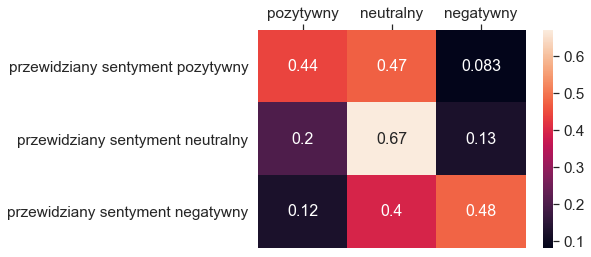

In [145]:
print(get_confusion_matrix(df_news))
plot_confusion_matrix(get_normalized_cfm(get_confusion_matrix(df_news)))

In [147]:
def save_df_to_excel(df, name):
  df.to_excel("{}.xlsx".format(name))

In [148]:
import itertools

# procedure for checking "sensitivity" of output
def get_combinations_of_sentences(sentences):
  words_combinations = []
  df = pd.DataFrame()
  for sentence in sentences:
    lst = sentence.split()
    words = []
    for L in range(0, len(lst)+1):
        for subset in itertools.combinations(lst, L):
            words.append(" ".join(subset))
    words.pop(0)
    #original_sentence = words[-1]
    words = words[-1:] + words[:-1]
    words_combinations.append(words)

  words_combinations = [inner for outer in words_combinations for inner in outer]
  #print(words_combinations)
  df["TWEET"] = words_combinations

  return df

def check_sensitivity(sentences, sort_by_closest_sentiment_score=False):
  df = get_combinations_of_sentences(sentences)
  df = get_output(df, False, False)

  if sort_by_closest_sentiment_score:
    sentiment_score = df["sentiment_score"]
    positive = df["positive"]
    neutral = df["neutral"]
    negative = df["negative"]
    tweet = df["TWEET"]
    tweet_scores_dict = {}
    tweet_scores_dict_sorted = {}
    for tw, pos, neg, neu, score in zip(tweet, positive, negative, neutral, sentiment_score):
      tweet_scores_dict[tw] = [pos, neg, neu, score]
    main_sentence_score = tweet_scores_dict[sentences[0]][3]
    # in order to show the closest sentiment scores to the original sentence we need to reorganise the data so that we are able to print dataframe with appropriate order
    for key, value in tweet_scores_dict.items():
      tweet_scores_dict[key] = [value[0], value[1], value[2], value[3], abs(value[3]-main_sentence_score)]
    # i teraz posortowac ascending by value[3]
    tweet_scores_sorted = sorted(tweet_scores_dict.items(), key=lambda x: x[1][4], reverse=False)
    for t in tweet_scores_sorted:
      tweet_scores_dict_sorted[t[0]] = t[1]

    # a pozniej podmienic value[3] na wlasciwy
    for key, value in tweet_scores_dict_sorted.items():
      tweet_scores_dict_sorted[key] = [value[0], value[1], value[2], value[3]]
    # i wtedy to na dataframe

    #print(tweet_scores_dict_sorted)
    df = pd.DataFrame.from_dict(tweet_scores_dict_sorted, orient='index', columns=['positive', 'negative', 'neutral', 'sentiment_score'])
  #return df.sort_values(by=['sentiment_score'], ascending=False)
  return df


In [149]:
df = check_sensitivity(["Today was a good day to buy bitcoin."])
df
#save_df_to_excel(df, "good_day_to_buy_bitcoin")

,TWEET,positive,negative,neutral,sentiment_score,predictions
0,Today was a good day to buy bitcoin.,0.806036,0.011631,0.182333,0.794405,positive
1,Today,0.058186,0.037012,0.904802,0.021174,neutral
2,was,0.077786,0.039463,0.882752,0.038323,neutral
3,a,0.073792,0.036795,0.889413,0.036997,neutral
4,good,0.141265,0.035385,0.823350,0.105879,neutral
5,day,0.071401,0.054659,0.873940,0.016742,neutral
6,to,0.066887,0.046863,0.886250,0.020024,neutral
7,buy,0.063705,0.038606,0.897689,0.025100,neutral
8,bitcoin.,0.024446,0.035437,0.940117,-0.010991,neutral
9,Today was,0.056204,0.031515,0.912281,0.024689,neutral


In [150]:
# order by closest to sentiment_score of main sentence
df = check_sensitivity(["Today was a good day to buy bitcoin."], True)
df

,positive,negative,neutral,sentiment_score
Today was a good day to buy bitcoin.,0.806036,0.011631,0.182333,0.794405
Today was good day bitcoin.,0.815965,0.020016,0.164019,0.795949
Today a good to,0.817432,0.034013,0.148555,0.783419
was good day to,0.802316,0.020262,0.177421,0.782054
Today was a good bitcoin.,0.828808,0.014906,0.156286,0.813902
Today was good day buy,0.790035,0.015294,0.194672,0.774741
Today a good day,0.837020,0.022191,0.140789,0.814829
was good buy,0.800777,0.031308,0.167915,0.769469
was a good day,0.846717,0.025915,0.127368,0.820802
Today was a good day to buy,0.782957,0.017463,0.199580,0.765494
